In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
pi = np.pi
clight = 299792458

In [22]:
working_folder = 'debug/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [24]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [25]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6
nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF == 2 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_ini)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print("Qs = ",Qs)

269.570327729
10015579420.0
0.0540982655071


In [26]:
with open(datafile, mode='rb') as file: # b is important -> binary
    test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

In [27]:
time = np.array(test[0::n_stride])
Ibi = np.array(test[1::n_stride])
#Ibi_1 = np.array(test[2::n_stride])
Ibi2 = np.array(test[3::n_stride])

V = []
Ig = []
#U = []
Vref = []
Iref = []
for i in range(nRF):
    V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
    Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
    
    Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
    Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))


52675398.06224871 -2370878.834450329
-29264110.034582615 -1317154.9080279607


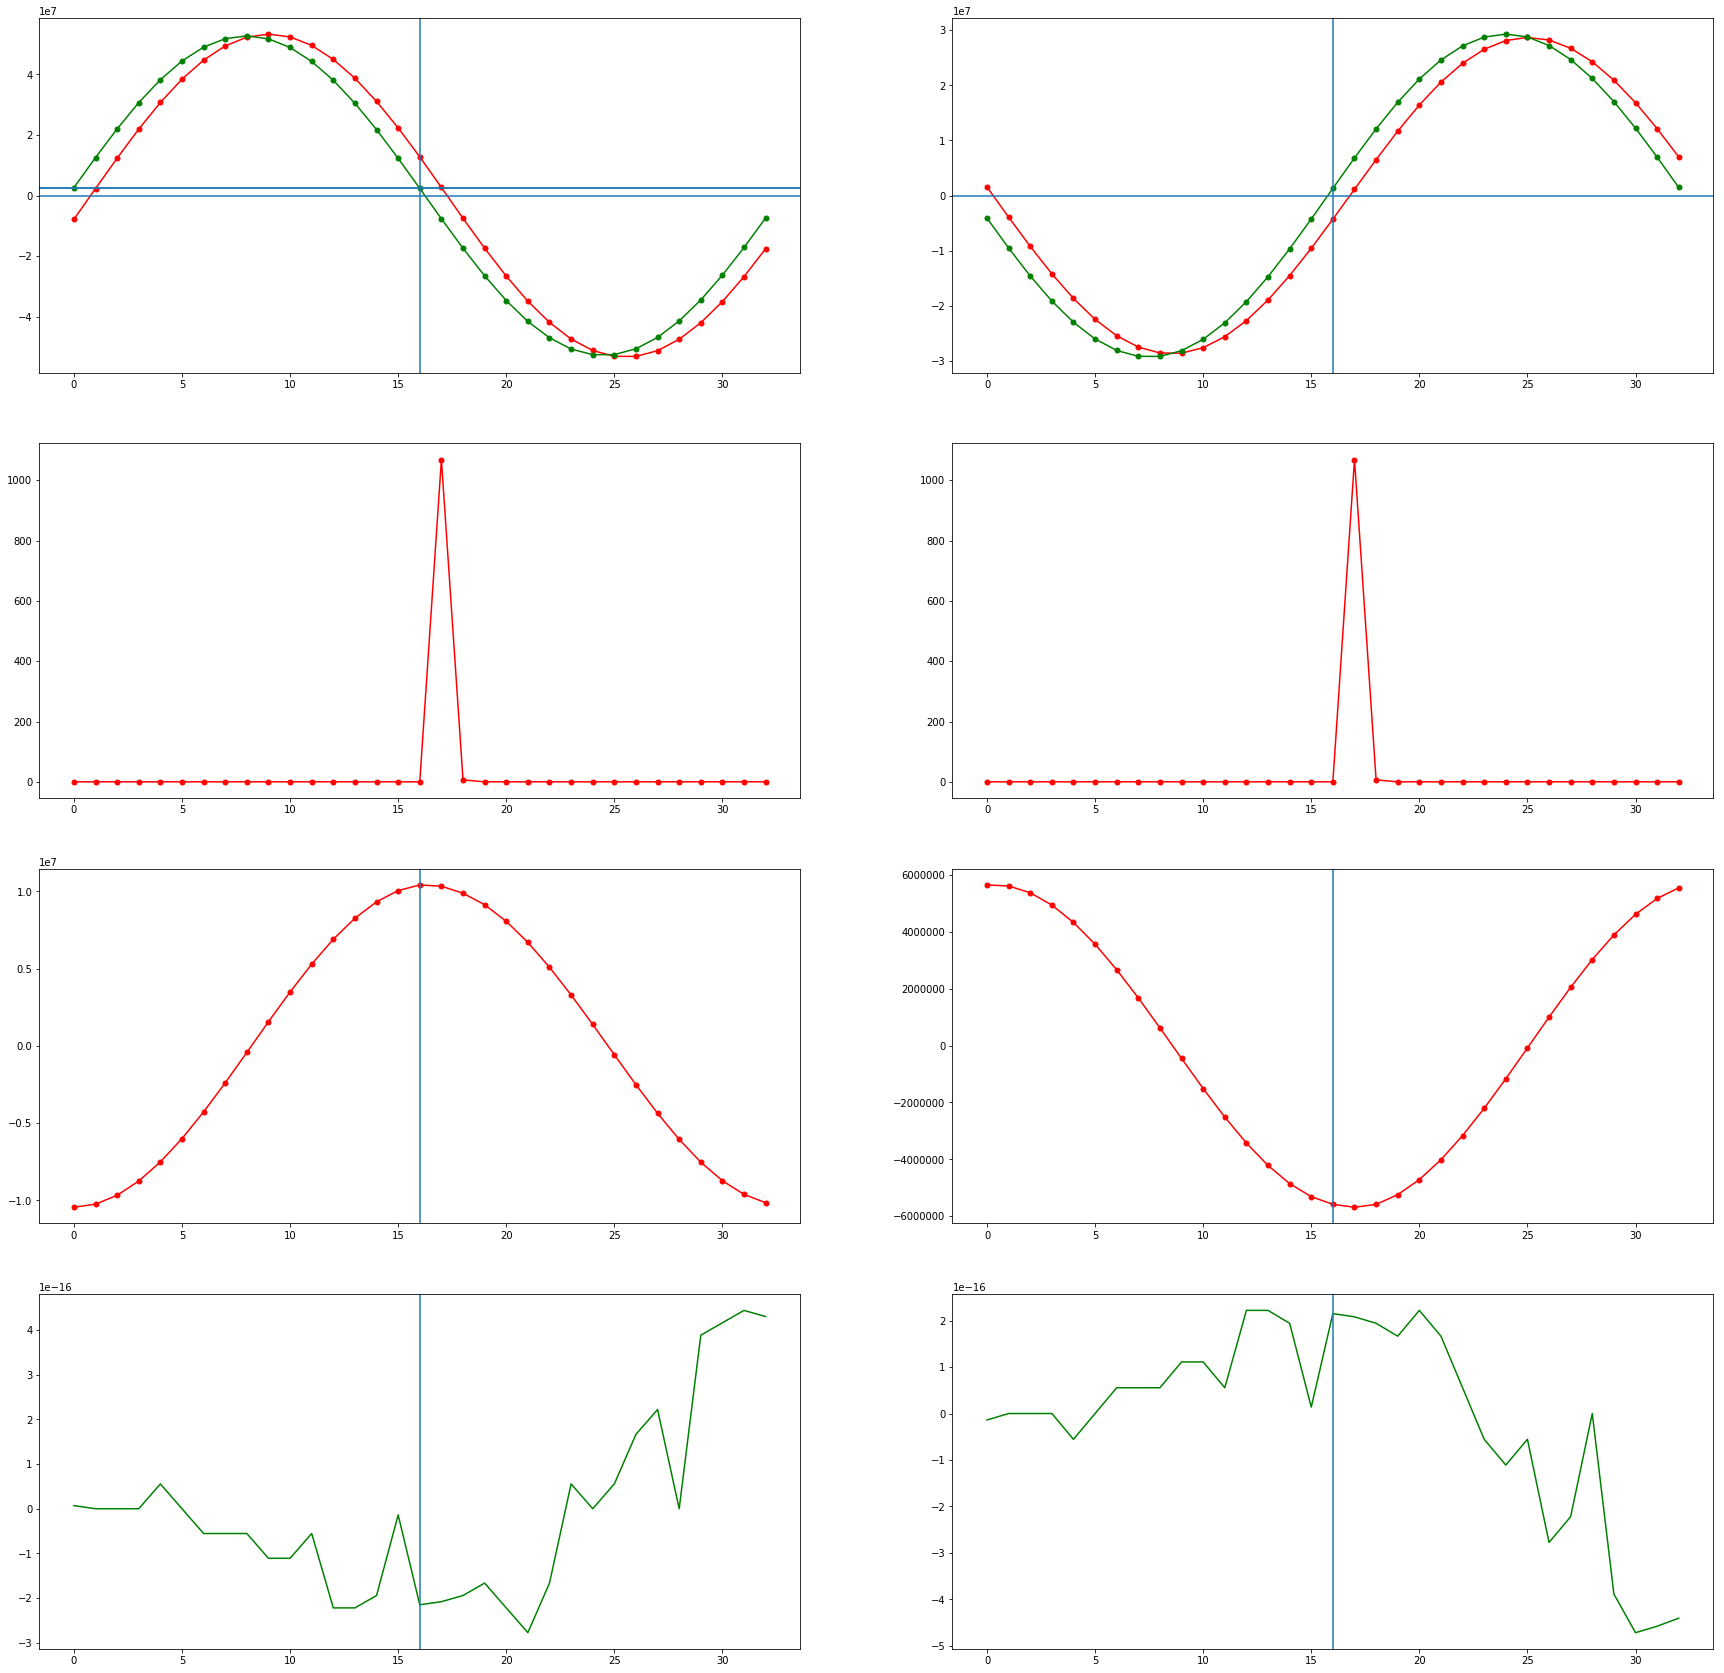

In [28]:
startTurn =9#int(nTurns/step-1)
startRF = 0*(nBunch-1)*fill_step
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*9)
        #axes1[0][1].axhline(y=3.7e6/14*6)
        #axes1[0][1].axhline(y=7.02e7)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].axvline(x=int(NpRF/2))
        #axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        #axes1[0][i].set_ylim([-3e6,3e6])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.5e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[2].set_ylim([-4e6,4e6])
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI2.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

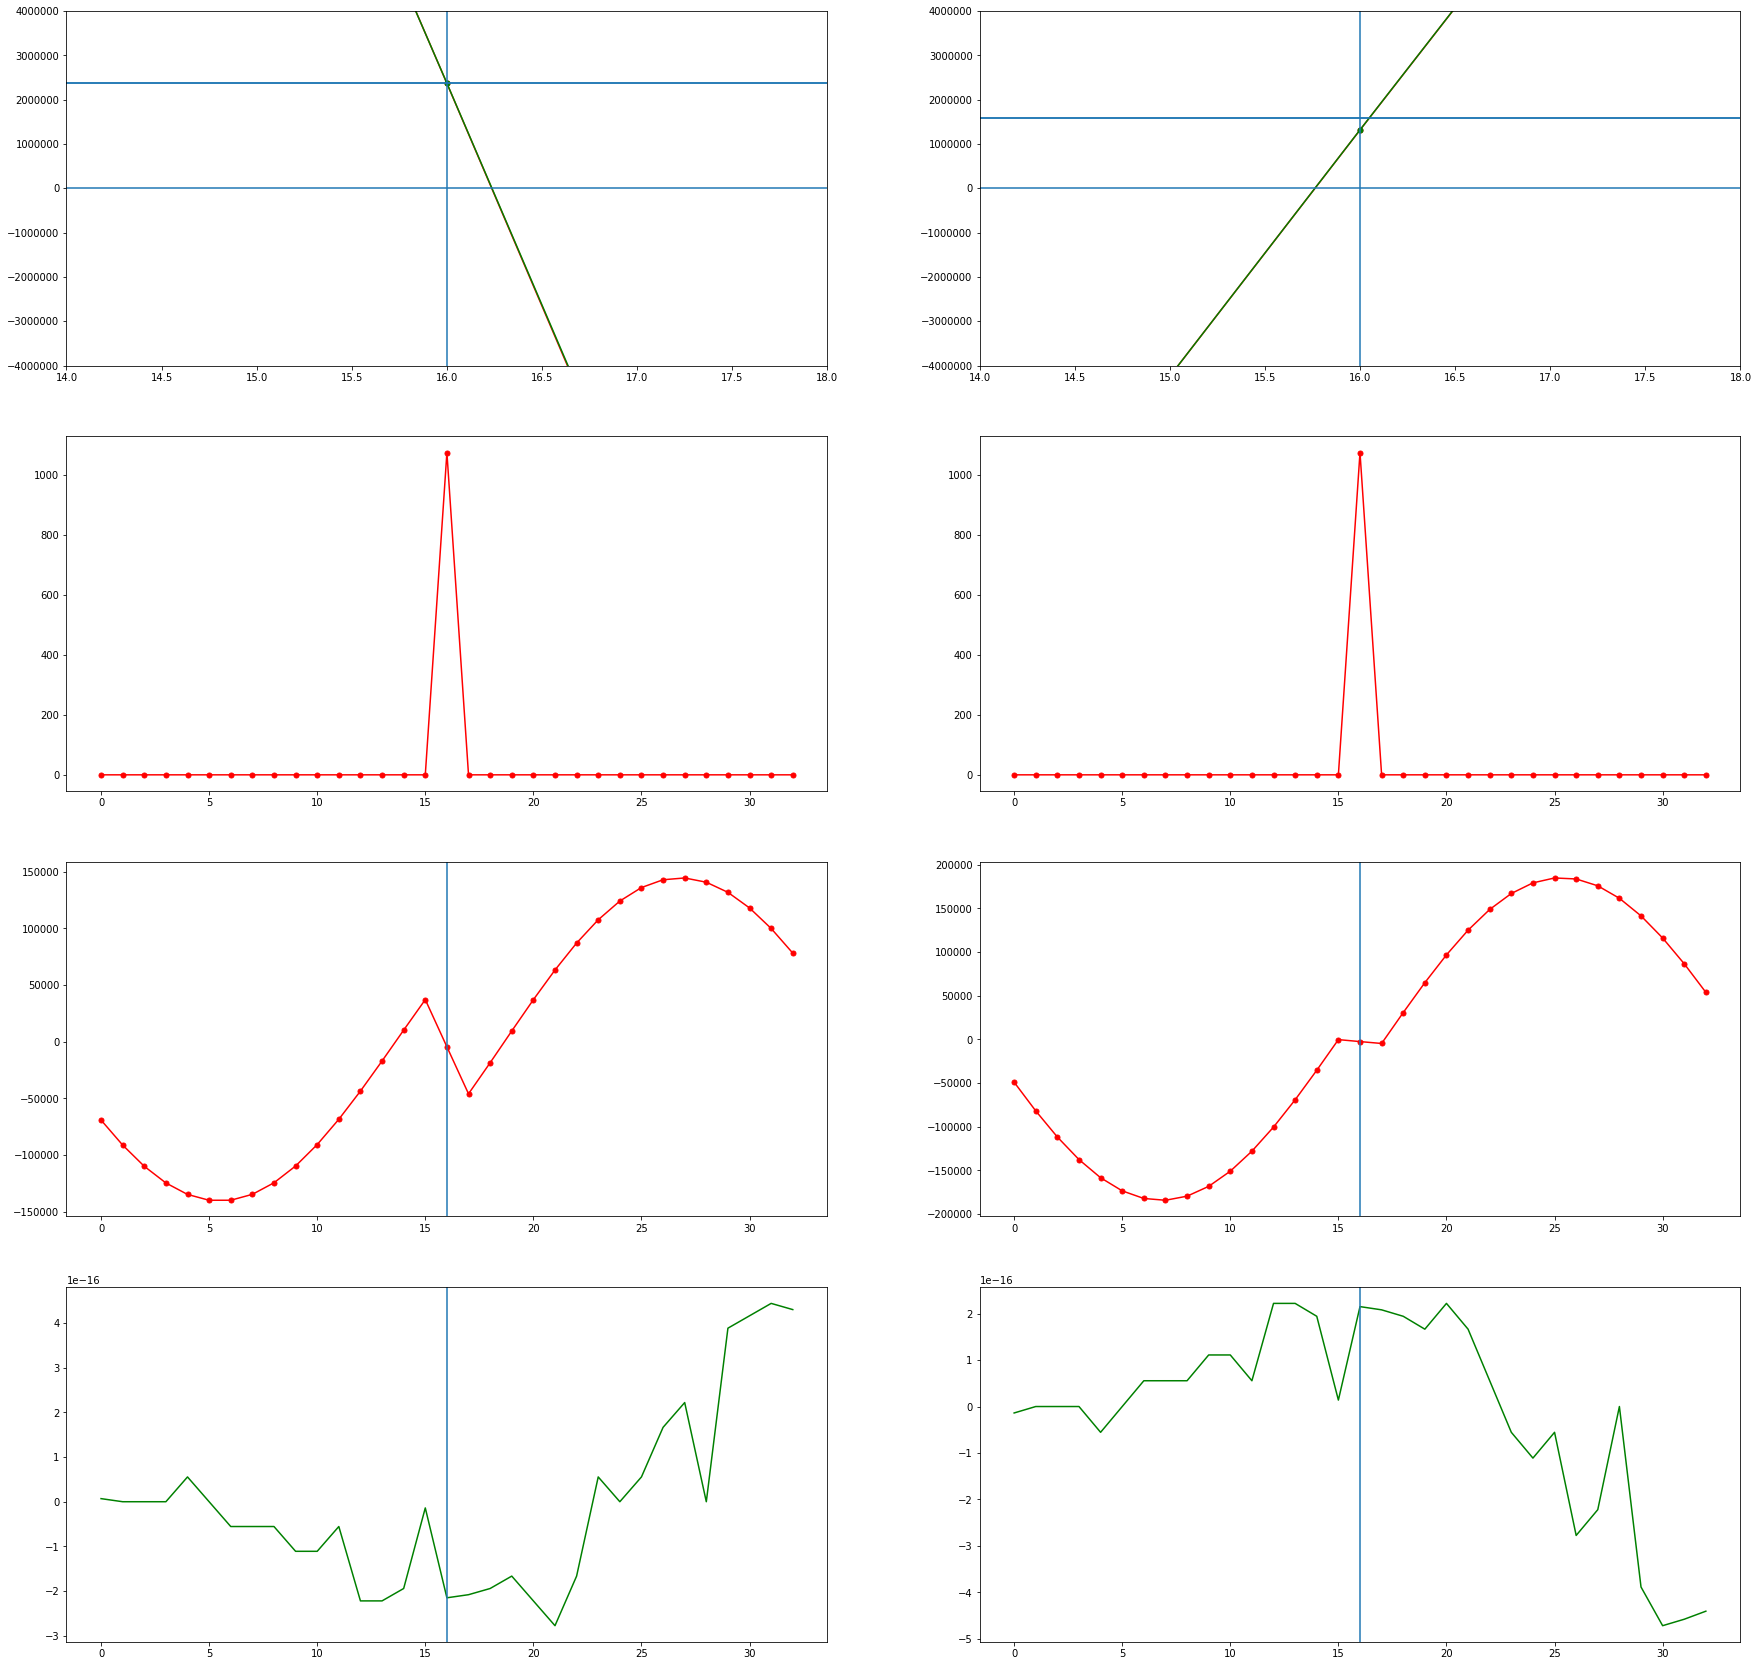

In [33]:
startTurn =3#int(nTurns/step-1)
startRF = 0*fill_step
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*9)
        #axes1[0][0].axhline(y=9.36e7)
        axes1[0][1].axhline(y=3.7e6/14*6)
        #axes1[0][1].axhline(y=7.02e7)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].axvline(x=int(NpRF/2))
        #axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        axes1[0][i].set_ylim([-4e6,4e6])
        axes1[0][i].set_xlim([int(NpRF/2)-2,int(NpRF/2)+2])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.5e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[2].set_ylim([-4e6,4e6])
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI2_'+str(startTurn)+'.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

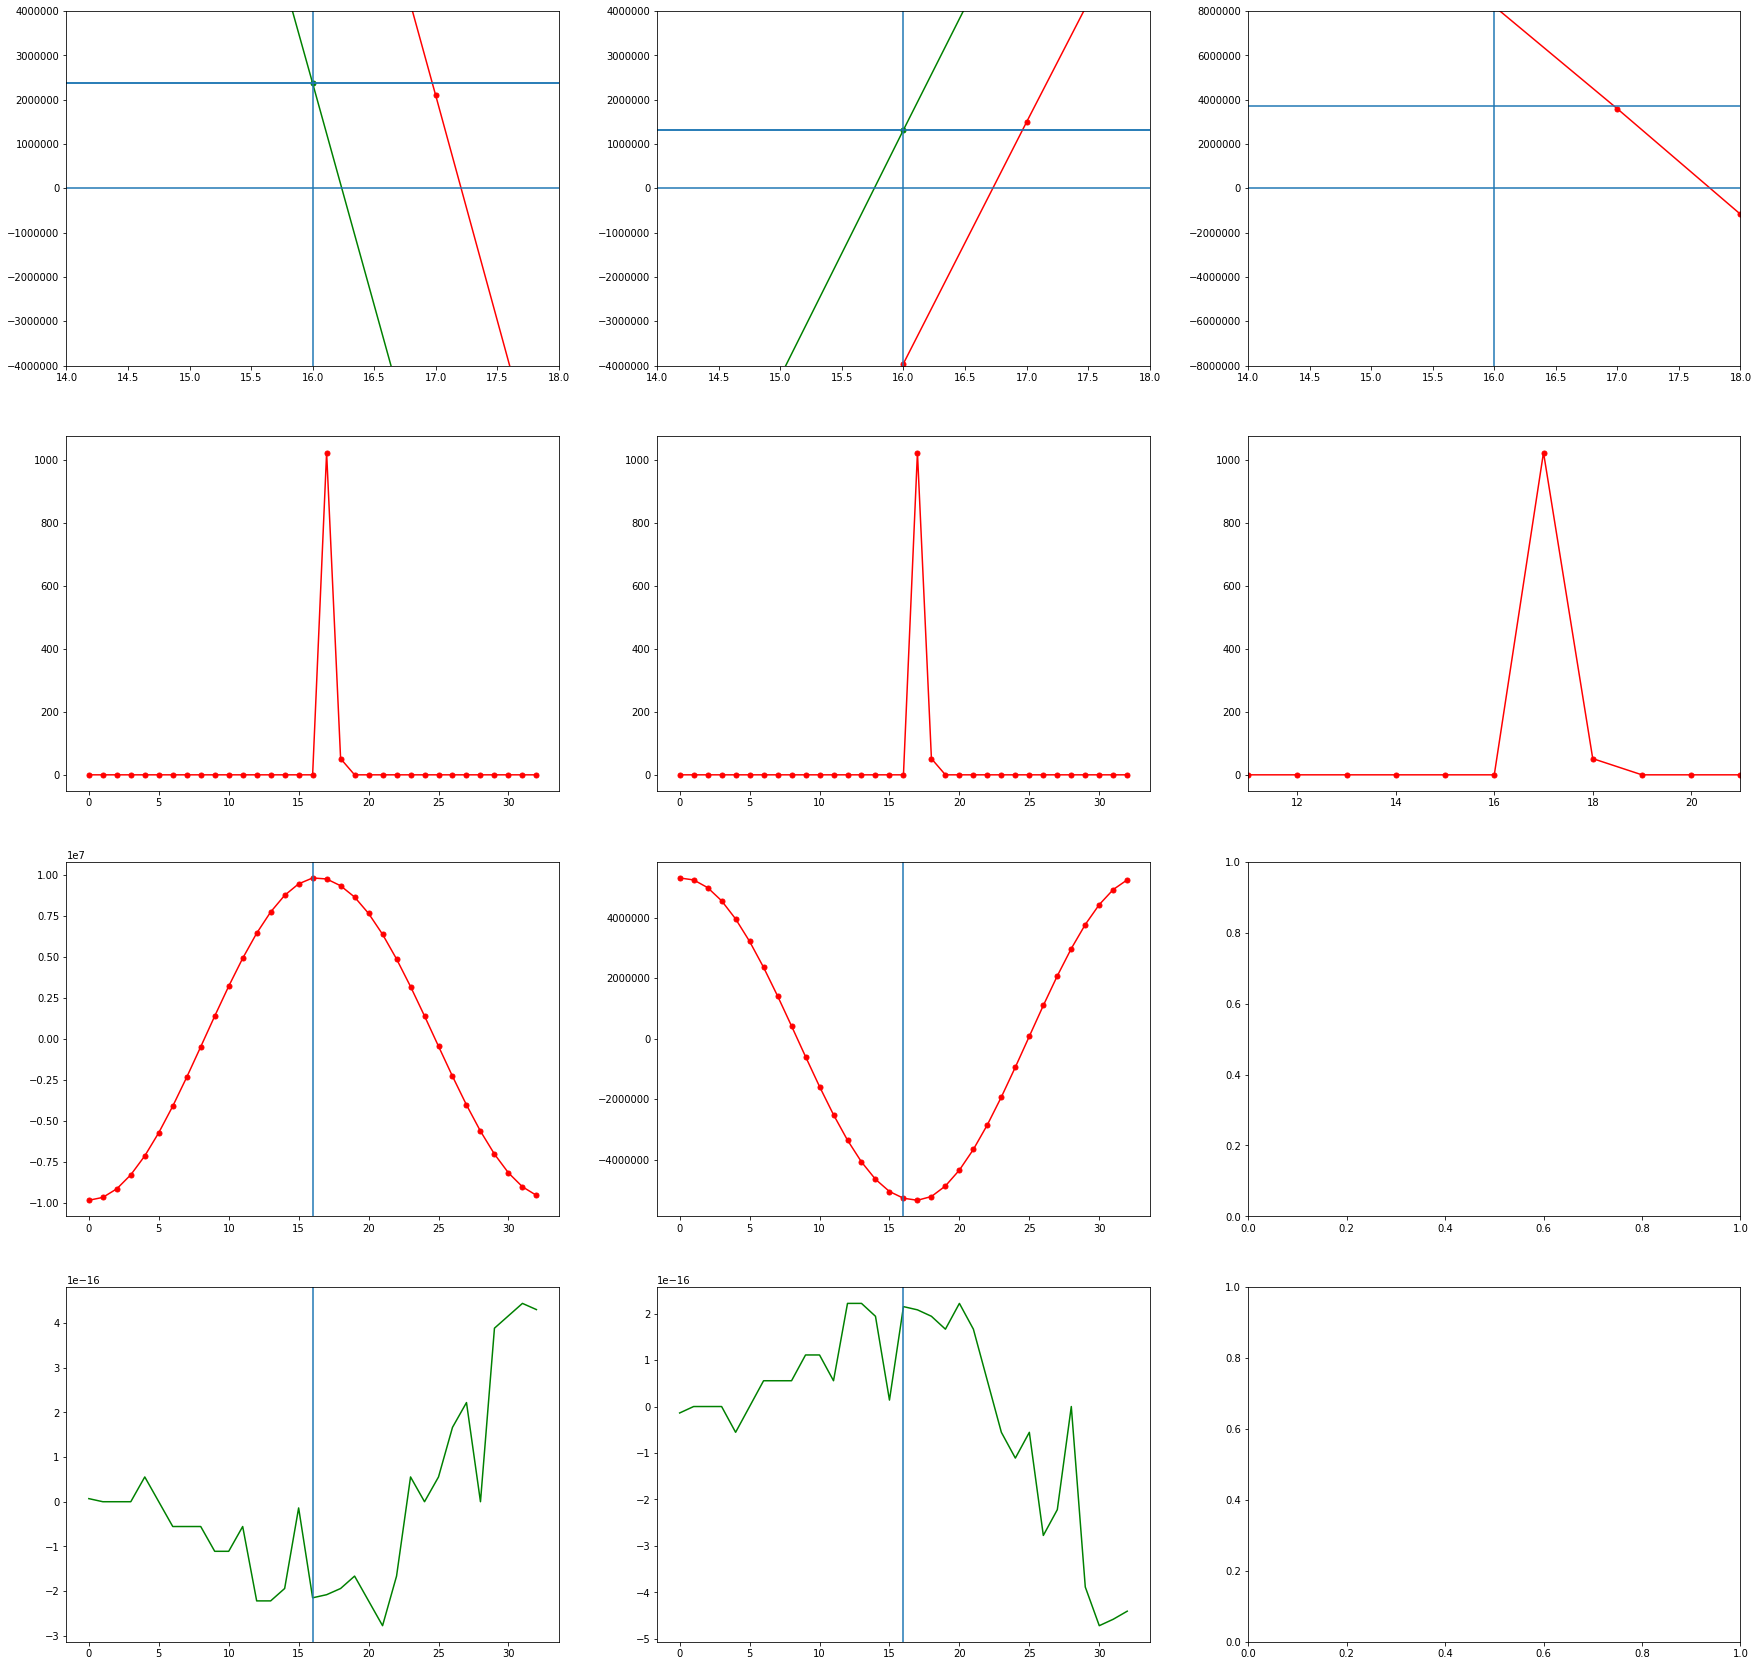

In [30]:
startTurn = 6#int(nTurns/step-1)
startRF = 0
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF+1)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*9)
        #axes1[0][0].axhline(y=9.36e7)
        axes1[0][1].axhline(y=3.7e6/14*5)
        #axes1[0][1].axhline(y=7.02e7)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].axvline(x=int(NpRF/2))
        #axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        axes1[0][i].set_ylim([-4e6,4e6])
        axes1[0][i].set_xlim([int(NpRF/2)-2,int(NpRF/2)+2])
    axes1[0][nRF].plot((V[0]+V[1])[rng1:rng2:step1],'r.-',ms=10)
    axes1[0][nRF].axhline(y=3.7e6)
    axes1[0][nRF].axhline(y=0)
    axes1[0][nRF].axvline(x=int(NpRF/2))
    axes1[0][nRF].set_ylim([-8e6,8e6])
    axes1[0][nRF].set_xlim([int(NpRF/2)-2,int(NpRF/2)+2])
    axes1[1][nRF].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
    axes1[1][nRF].set_xlim([int(NpRF/2)-5,int(NpRF/2)+5])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.5e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[2].set_ylim([-4e6,4e6])
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI2_'+str(startTurn)+'.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

In [31]:
turn_to_look = 0*int(nTurns/step-1)
idx1 = turn_to_look*NpRF*h[0]+int(NpRF/2)
idx2 = idx1+(h[0]-1)*NpRF*99
V_beam_see = V[0][idx1::NpRF*fill_step]
V_beam_see_ref = Vref[0][idx1::NpRF*fill_step]


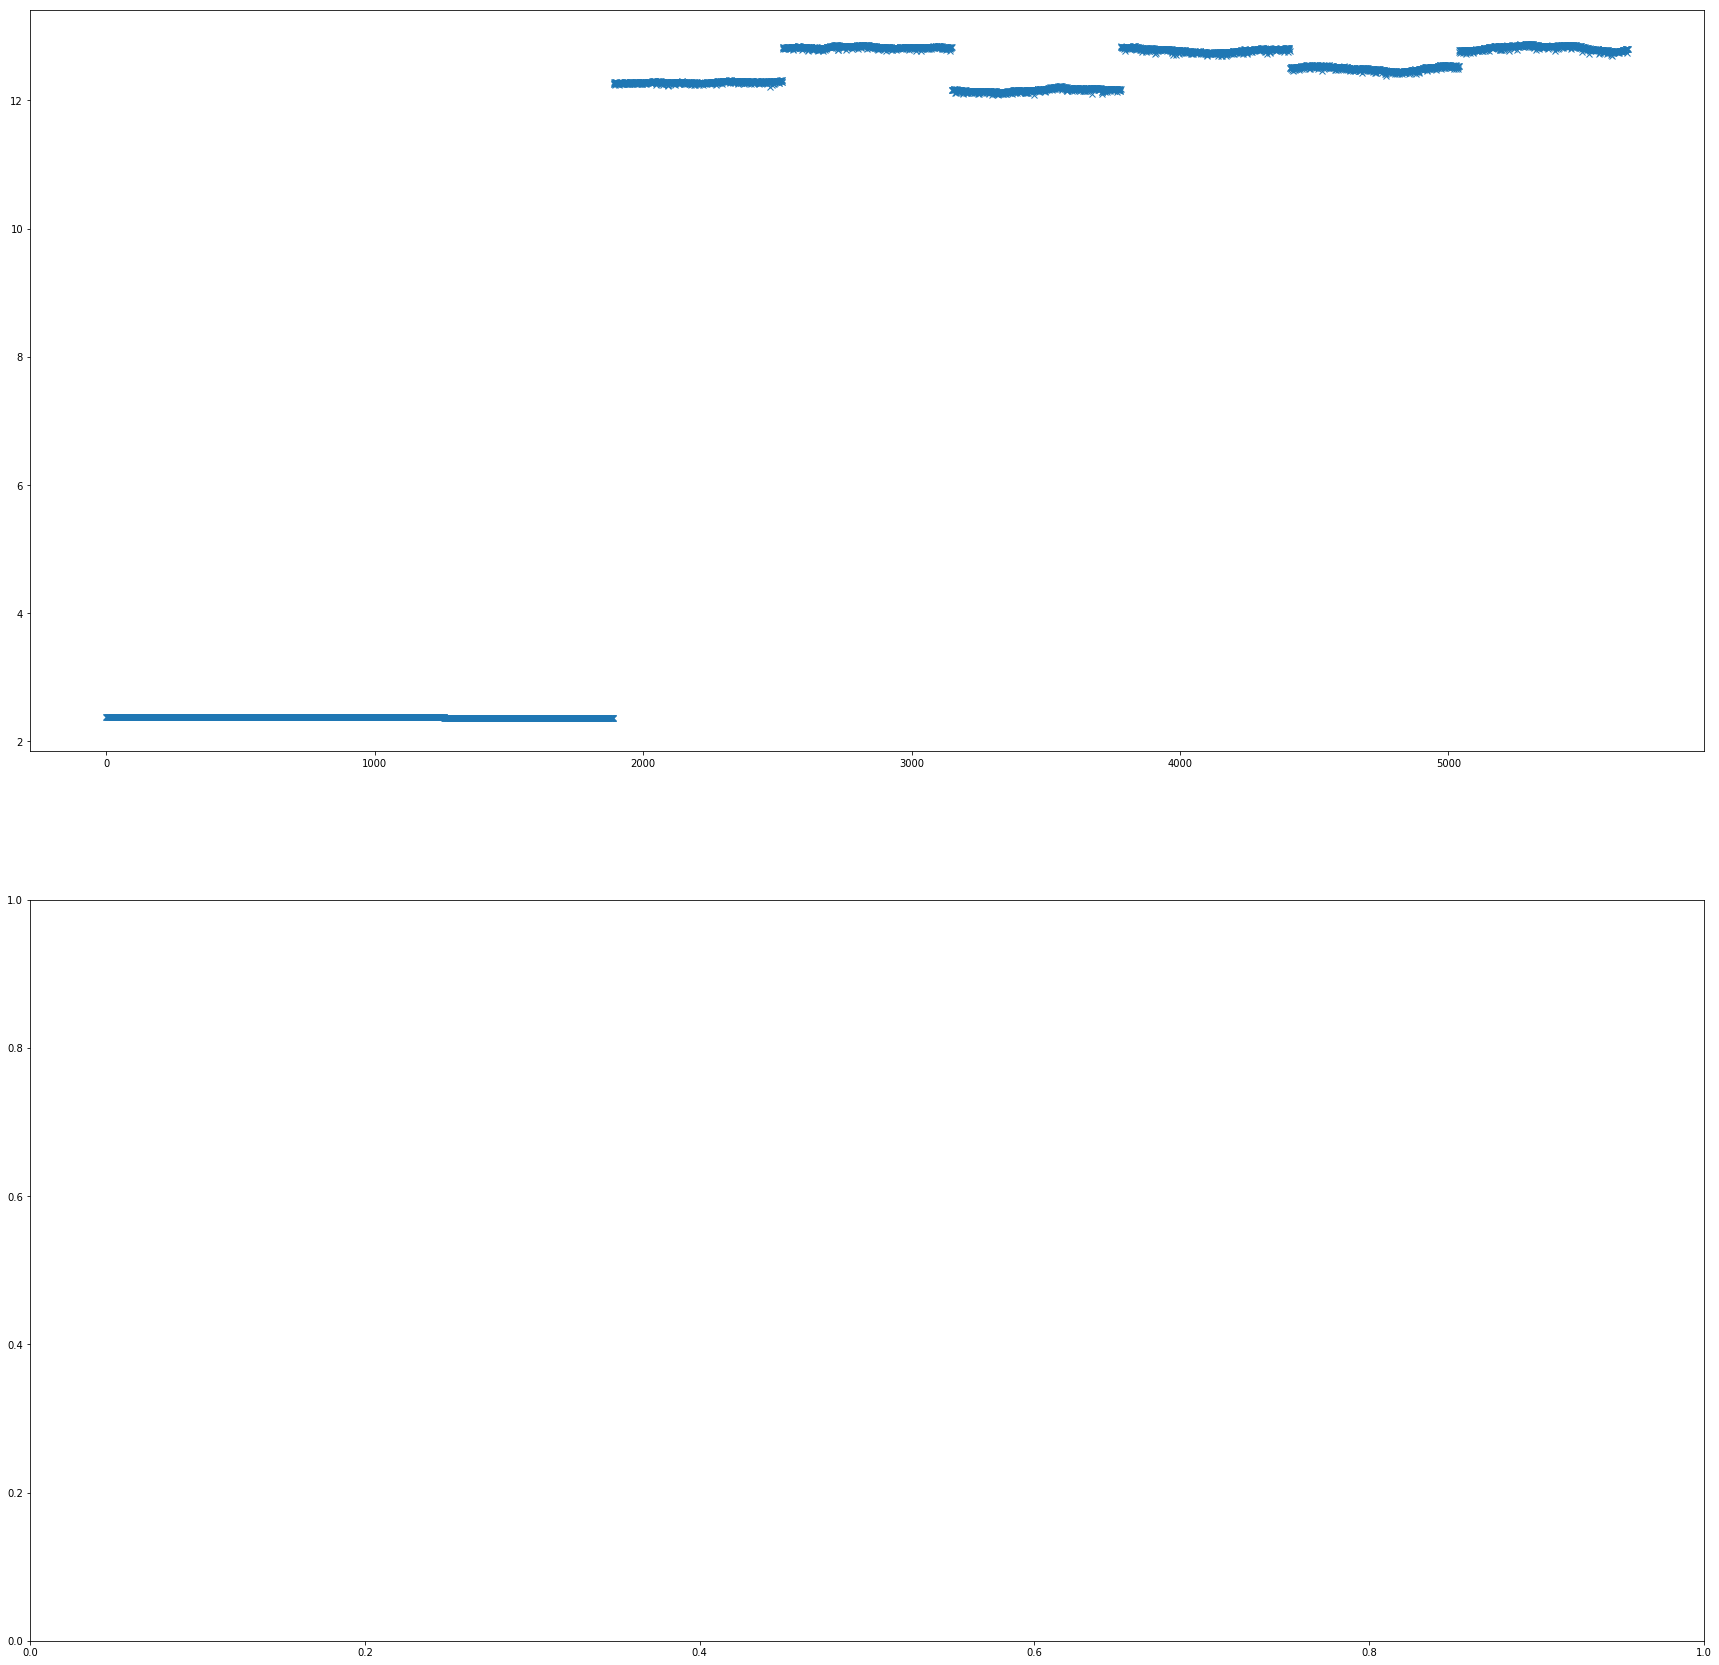

In [32]:
rng1 = 1*int(h[0]/fill_step)
rng2 = rng1+int(h[0]/fill_step)*30
fig1,axes1 = plt.subplots(2,1)
axes1[0].plot(V_beam_see[rng1:rng2]/1e6,'x')
#axes1[1].plot(V_beam_see_ref)
fig1.set_figheight(30)
fig1.set_figwidth(30)
plt.show()

In [69]:
2*pi*63e3*T0*50/630/pi*180

23.018995372892935

In [ ]:
startTurn =int(nTurns/step-10)
startRF = 0
nRFsamp = h[0]*9

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0

Vfft = np.fft.fft(V[0][rng1:rng2])
Vreffft = np.fft.fft(Vref[0][rng1:rng2])
Vfreq = np.fft.fftfreq(len(V[0][rng1:rng2]),d = T0/NpRF/h[0])
bin_res = np.argmax(np.abs(Vfft))
span = 200
fig1,axes1 = plt.subplots(1,1)
axes1.plot(Vfreq[bin_res-span:bin_res+span]/1e6,np.log10(np.abs(np.abs(Vfft[bin_res-span:bin_res+span]))+1),'r.-')
axes1.axvline(x=(f+delta_f)/1e6)
axes1.axvline(x=(f)/1e6)
axes1.axvline(x=(f-f0)/1e6)

axes1.set_ylabel('Log[FFT[V]]',fontsize=30)
axes1.set_xlabel('f (MHz)',fontsize=30)
#plt.plot(Vfreq[151100:151300]/1e6,np.abs(Vreffft[151100:151300]))
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_vfft = os.path.join(cwd,'Vfft.jpg')
fig1.savefig(fn_vfft,bbox_inches='tight')
plt.show()


In [ ]:
Igfft = np.fft.fft(Ig[0][rng1:rng2])
Igreffft = np.fft.fft(Iref[0][rng1:rng2])
Igfreq = np.fft.fftfreq(len(Ig[0][rng1:rng2]),d = T0/NpRF/h[0])
bin_res = np.argmax(np.abs(Igfft))
fig1,axes1 = plt.subplots(1,1)
span = 200

axes1.plot(Igfreq[bin_res-span:bin_res+span]/1e6,np.log(np.abs(Igfft[bin_res-span:bin_res+span])+1),'rx-')
#axes1.plot(Igfreq[bin_res-50:bin_res+50]/1e6,np.abs(np.abs(Igreffft[bin_res-50:bin_res+50])),'g.-')
#axes1.set_ylim([0,1e-3])

axes1.axvline(x=(f-f0)/1e6)
axes1.axvline(x=(f+delta_f)/1e6)

axes1.axvline(x=(f)/1e6)

axes1.set_ylabel('FFT[Ig]',fontsize=30)
axes1.set_xlabel('f (MHz)',fontsize=30)

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
fn_igfft = os.path.join(cwd,'Igfft.jpg')
fig1.savefig(fn_igfft,bbox_inches='tight')
plt.show()


In [ ]:
def gaussian(sig,mu,x):
#    return np.exp(-0.5*(i/sig)**2)
    return np.array([np.exp(-0.5*(i/sig)**2) for i in x])

def lorentz(f0,Q,R,f_range):# f0 is the center of the peak, Q is the Q, R is the peak hieght of the peak, f_range is the whole frequency range.
    return R/(1+1j*Q*(f_range/f0-f0/f_range))

In [ ]:
w = Igfreq
w[0]=1e-100
Zres = lorentz(f+delta_f,Qbeam,Rsh*2,w)
IZ = Igfft*Zres
V_iFFT = np.fft.ifft(IZ)

In [ ]:
fig1,axes1 = plt.subplots(1,1)
span = 200
axes1.plot(Igfreq[bin_res-span:bin_res+span]/1e6,np.abs(np.abs(Zres[bin_res-span:bin_res+span])+1),'rx-')
#axes1.plot(Igfreq[bin_res-50:bin_res+50]/1e6,np.abs(np.abs(Igreffft[bin_res-50:bin_res+50])),'g.-')

axes1.axvline(x=(f+delta_f)/1e6)
axes1.axvline(x=(f)/1e6)

axes1.set_ylabel('FFT[Ig]',fontsize=30)
axes1.set_xlabel('f (MHz)',fontsize=30)
#plt.plot(Vfreq[151100:151300]/1e6,np.abs(Vreffft[151100:151300]))
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_zfft = os.path.join(cwd,'Zfft.jpg')
fig1.savefig(fn_zfft,bbox_inches='tight')
plt.show()


In [ ]:
fig1,axes1 = plt.subplots(1,1)
span = 200
axes1.plot(Igfreq[bin_res-span:bin_res+span]/1e6,np.log(np.abs(IZ[bin_res-span:bin_res+span])+1e-20),'rx-')
axes1.plot(Igfreq[bin_res-span:bin_res+span]/1e6,np.log(np.abs(Vfft[bin_res-span:bin_res+span])+1e-20),'g.-')

#axes1.plot(Igfreq[bin_res-50:bin_res+50]/1e6,np.abs(np.abs(Igreffft[bin_res-50:bin_res+50])),'g.-')

axes1.axvline(x=(f+delta_f)/1e6)
axes1.axvline(x=(f)/1e6)

axes1.set_ylabel('FFT[Ig]',fontsize=30)
axes1.set_xlabel('f (MHz)',fontsize=30)
#plt.plot(Vfreq[151100:151300]/1e6,np.abs(Vreffft[151100:151300]))
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_izfft = os.path.join(cwd,'IZfft.jpg')
fig1.savefig(fn_izfft,bbox_inches='tight')
plt.show()


In [ ]:
np.max(IZ)

In [ ]:
np.max(Vfft)

In [ ]:
datafile = 'f_cav.bin'
datafile = os.path.join(cwd,datafile)
pattern = nRF*'d'
stride = len(pattern)*8
with open(datafile, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
data = np.array([struct.unpack(pattern,fileContent[i*stride:(i+1)*stride]) for i in range(int(len(fileContent)/stride))]).T
frqs = []
for i in range(nRF):
    frqs.append(np.array(data[i])/2/np.pi)

In [ ]:
V_max = []
Ig_max = []
for i in range(nRF):
    V_max.append([])
    Ig_max.append([])
    for j in range(int(len(V[i])/NpRF/h[0])-1):
        V_max[i].append(np.max(V[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
        #Ig_max[i].append(np.max(Ig[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))

In [ ]:
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
if nRF>1:
    fig1,axes1 = plt.subplots(2,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V_max[i][start:end],'r.-',ms=10)
        #axes1[0][i].set_yscale('log')
        axes1[1][i].axhline(y = h[i])
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])+1)
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])-1)
        #axes1[2][i].plot(Ig_max[i][start:end],'r.-',ms=10)
        axes1[1][i].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)        
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V_max[i][start:end],'r.-',ms=10)
        axes1[1].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)   
        #axes1[1].axhline(y = omegarf[i]/(omegarf[0]/h[0]))
        
fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'process.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [ ]:
datafilepar = 'init.bin'
datafilepar = os.path.join(cwd,datafilepar)
pat = nTot*'d'
strd = nTot*8
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack(pat,fileContent[i*strd:(i+1)*strd]) for i in range(int(len(fileContent)/strd))])
dt_init = np.array(datapar[0])
gamma_init = np.array(datapar[1])

In [ ]:
rng1 =  0*nPar
rng2 = int(1*nPar)
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'r.',ms=10)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[16])
#axes1.axvline(x = bin_centers[16]+7.7e-10)
#axes1.axvline(x = bin_centers[16]-7.7e-10)
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0],bin_centers[-1]])

fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

In [ ]:
dt1 = dt_init[rng1:rng2:step1]
delta1 = gamma_init[rng1:rng2:step1]#*(197*931.5e6) # convert into eV
sig_dt1_sqr = np.sum((dt1-np.sum(dt1)/len(dt1))**2)/len(dt1)
sig_delta1_sqr = np.sum((delta1-np.sum(delta1)/len(delta1))**2)/len(delta1)
sig_dt1_delta1 = np.sum((delta1-np.sum(delta1)/len(delta1))*(dt1-np.sum(dt1)/len(dt1)))/len(delta1)
emittance = np.sqrt(sig_dt1_sqr*sig_delta1_sqr-sig_dt1_delta1**2)*np.pi*(197*931.5e6)
print(sig_dt1_sqr**0.5)
print(sig_delta1_sqr**0.5)
print(emittance*6/197)

In [ ]:
datafilepar = 'par.bin'
datafilepar = os.path.join(cwd,datafilepar)
nData = int(nTurns/step)
par_store_tot = nTot*nData
pat = nTot*'d'*2
strd = nTot*8*2
datapar = array('d')

with open(datafilepar, mode='rb') as file: # b is important -> binary
    datapar.fromfile(file,par_store_tot*2)
    
dt = np.zeros(par_store_tot)
gamma = np.zeros(par_store_tot)
for i in range(nData):
    dt[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[i*nBeam*nPar*nBunch*2:(i*2+1)*nPar*nBunch*nBeam]
    gamma[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[(i*2+1)*nBeam*nPar*nBunch:(i*2+2)*nPar*nBunch*nBeam]
    #dt.append(datapar[i*2*nPar*nBunch*2:(i*2+1)*nPar*nBunch*2])
    #gamma.append(datapar[(i*2+1)*nPar*nBunch*2:(i*2+2)*nPar*nBunch*2])

In [ ]:
turn_display = 39
bunch_display = 0
nBunch_display = 1
rng11 =  turn_display*nBunch*nBeam*nPar+(bunch_display)*nPar
rng21= turn_display*nBunch*nBeam*nPar+(bunch_display+nBunch_display)*nPar

rng1 = (bunch_display)*nPar
rng2 = (bunch_display+nBunch_display)*nPar
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'rx',ms=15)
axes1.plot(dt[rng11:rng21:],gamma[rng11:rng21:]-Gamma0,'g.',ms=15)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[32]+3*Trf[0])
#axes1.axvline(x = bin_centers[32]+7.7e-10+3*Trf[0])
#axes1.axvline(x = bin_centers[32]-7.7e-10+3*Trf[0])
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0]-bunch_display/(f0*h[0])*6,bin_centers[NpRF-1]+bunch_display/(f0*h[0])*6])
axes1.set_xlim([bin_centers[0]+bunch_display*3*Trf[0],bin_centers[NpRF-1]+bunch_display*3*Trf[0]])

fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

Get the mask for bunch M1 and M2 calculation

In [ ]:
def get_bucket_limits(bucket_lower_lim,bucket_upper_lim,beam_shift,Trf,Trev,nParPerData,nParPerTurn,nPar):
    bucket_lower_lim = np.mod(((np.mod(np.mod(bucket_lower_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_lower_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25))*Trf,Trev)
    bucket_upper_lim = np.mod(((np.mod(np.mod(bucket_upper_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_upper_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25)+1)*Trf,Trev)
    #bucket_lower_lim = (((bucket_lower_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_lower_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5))*Trf
    #bucket_upper_lim = (((bucket_upper_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_upper_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5)+1)*Trf
    return bucket_lower_lim,bucket_upper_lim
def get_mask(bucket_lower_lim, bucket_upper_lim,dt,mask):
    mask = np.abs((np.sign((dt-bucket_lower_lim)*(dt-bucket_upper_lim))-1)/2).astype(bool)
    return mask

In [ ]:
bucket_lower_lim3 = np.arange(start=0, stop=len(dt))
bucket_upper_lim3 = np.arange(start=0, stop=len(dt))
mask = np.ones(len(dt))

In [ ]:
mask

In [ ]:
bucket_lower_lim3

In [ ]:
bucket_upper_lim3

In [ ]:
bucket_lower_lim3,bucket_upper_lim3 = get_bucket_limits(bucket_lower_lim3,bucket_upper_lim3,beam_shift,Trf[0],T0,nBeam*nBunch*nPar,nBunch*nPar,nPar)

In [ ]:
mask = get_mask(bucket_lower_lim3, bucket_upper_lim3,dt,mask)

In [ ]:
mask[::nPar*nBunch]

Calculate the M1 and M2 for all bunches in all recorded data

In [ ]:
dt_mask = dt*mask
gamma_mask = gamma*mask

t_0 = np.zeros(nData*nBeam*nBunch)
gamma_0 = np.zeros(nData*nBeam*nBunch)
nPar_mask = np.zeros(nData*nBeam*nBunch)
sig_t = np.zeros(nData*nBeam*nBunch)
sig_gamma = np.zeros(nData*nBeam*nBunch)
sig_t_gamma = np.zeros(nData*nBeam*nBunch)
emittance = np.zeros(nData*nBeam*nBunch)
    
for i in range(nData*nBeam*nBunch):
    nPar_mask[i] = np.sum(mask[i*nPar:(i+1)*nPar])
for i in range(nData*nBeam*nBunch):
    t_0[i] = np.sum(dt_mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    gamma_0[i] = (np.sum(gamma_mask[i*nPar:(i+1)*nPar]))/nPar_mask[i]

In [ ]:
for i in range(nData*nBeam*nBunch):
    sig_t[i] = np.sum(((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_gamma[i] = np.sum(((gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_t_gamma[i] = np.sum((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*(gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    emittance[i] = np.sqrt(sig_t[i]*sig_gamma[i]-sig_t_gamma[i]**2)*np.pi*(197*931.5e6)*6/197

In [ ]:
nPar_mask

In [ ]:
# plot average gamma along the train.
turn_display = 3#int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(gamma_0[rng1:rng2:]-Gamma0,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('Delta Gamma',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

In [ ]:
# plot average arriving time of the centroid along the train.
turn_display = 176#int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(rng2-rng1)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)/Trf[0]*360,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('dphi along train',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

In [ ]:
# plot average distance shift of the centroid along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)*clight*100,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('longitudianl shift along train (cm)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train_dist.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

In [ ]:
# emittance plot
turn_display = 180
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(emittance[rng1:rng2:],'rx-')
fn_emittance = os.path.join(cwd,'Emittance.jpg')
plt.savefig(fn_emittance,bbox_inches='tight')
plt.show()

In [ ]:
# particle loss
turn_display = 175
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]

axes1.plot(nPar_mask[rng1:rng2:],'rx')
plt.show()

In [ ]:
# I peak
I_peak = np.zeros(nData)
for i in range(nData):
    I_peak[i] = np.max(Ibi[i*NpRF*h[0]:(i+1)*NpRF*h[0]])

fig1,axes1 = plt.subplots(1,1)
axes1.plot(I_peak,'rx-')

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of Turn [X'+str(step)+']',fontsize=30)
axes1.set_ylabel('I_peak',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_Ipeak = os.path.join(cwd,'Ipeak.jpg')
plt.savefig(fn_Ipeak,bbox_inches='tight')
plt.show()

In [ ]:
datafilepar = 'first.bin'
datafilepar = os.path.join(cwd,datafilepar)
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack('dd',fileContent[i*16:(i+1)*16]) for i in range(int(len(fileContent)/16))]).T
first_dt = np.array(datapar[0])
first_gamma = np.array(datapar[1])

In [ ]:
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh/(1+1j*QL*(omega/omega0-omega0/omega))


In [ ]:
#r0 = (79*1.6e-19)**2/(197*1.7e-27*3e8*3e8)
r0 = (1*1.6e-19)**2/(1*1.7e-27*3e8*3e8)

pmax = 40
mu = h[mainRF]%nBunch

ps = np.array([float(i) for i in range(-pmax,pmax)])
ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

# for the calculation of real part of Omega
p_M_omega0 = ps*nBunch*2*np.pi*f0
Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
delta_omegas = factor1*np.sum(p_M_omega0*np.imag(Zs0))
omegas = Qs*2*pi*f0+delta_omegas

omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
deltaOmegaRe = factor1*np.sum(omegas1*np.imag(Zs1))

# for the calculation of the imaginary part of Omega
omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
print(deltaOmegaRe)
print(deltaOmegaIm)

In [ ]:
# Fitted
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c

if 1:
    startTurn = 0
    endTurn = 20000
    delta_gamma_env = np.zeros(int((endTurn-startTurn)*Qs))
    TTurns = int(1/Qs) # numbers of turns per synchrotron oscillation
    delta_gamma_turn = np.array([i*TTurns+startTurn for i in range(len(delta_gamma_env))])
    delta_gamma_time = delta_gamma_turn*T0
    for i in range(len(delta_gamma_env)):
        delta_gamma_env[i] = np.max(first_gamma[i*TTurns+startTurn:(i+1)*TTurns+startTurn])-Gamma0
    popt, pcov = curve_fit(func_exp_fit, delta_gamma_time, \
                           delta_gamma_env,bounds=([-1e-1,0,-1e-1], [1, deltaOmegaIm*2, 1]),\
                           maxfev=2000000)
    print(popt)
    print(pcov)

    print("Fitted Tau = ",1/popt[1])
    delta_gamma_fitted = popt[0]*np.exp(popt[1]*delta_gamma_time)+popt[2]
    # Analytical
    print("TauAnalytical = ",1/deltaOmegaIm)
    TauInver = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)*(h[mainRF]*2*np.pi*f0+f0*Qs*2*np.pi)*R[mainRF]
    print("TauSimplified  = ",1/TauInver)
    TauInver = deltaOmegaIm
    print("Fitted Tau     = ",1/popt[1])
    TauInver = (deltaOmegaIm-Qs/Ek_damp/2/T0)
    print("Tau_including_artificial_Damping_Term = ",1/TauInver)

    temp_time = np.array([i*T0 for i in range(len(first_gamma))])

    analy = popt[0]*np.exp(TauInver*delta_gamma_time)+popt[2]
    rng1 =  0
    rng2 = 20000#int(nTurns-1)

    step1 = 1

    fig1,axes1 = plt.subplots(1,1)

    axes1.plot(first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=1)
    axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_env[rng1:int(rng2/TTurns):step1],'g.-',ms=5)
    axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_fitted[rng1:int(rng2/TTurns):step1],'b.-',ms=20)
    #axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],analy[rng1:int(rng2/TTurns):step1],'y.-',ms=30)
    #axes1.set_yscale('log')

    #axes1.plot(first_dt[rng1:rng2:step1],first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=10)

    #axes1.plot(first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)
    #axes1.plot(first_dt[rng1:rng1+10:step1],first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)

    #axes1.plot(first_gamma[rng2-1000:rng2:step1]-Gamma0,'b.-',ms=30)

    axes1.set_xlabel('# of Turn',fontsize=30)
    axes1.set_ylabel('Delta Gamma',fontsize=30)
    axes1.tick_params(labelsize=30)
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.7f'))

    axes1.legend(['Simulated','Envelope',f'Fitted,        Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
    #axes1.axhline(y=bucket_height)
    #axes1.axhline(y=-bucket_height)

    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    fn_Bench = os.path.join(cwd,'Bench.jpg')
    plt.savefig(fn_Bench,bbox_inches='tight')
    print('eta = ',eta)
    print('Qs = ',Qs)
    print('f0 = ',f0)
    print('fs = ',Qs*f0)
    plt.show()

In [ ]:
delta_gamma_env

In [ ]:
gamma_fft = np.fft.fft(first_gamma-Gamma0)
w = np.fft.fftfreq(len(first_gamma),d=1/f0)
rng1 =  0
rng2 = int(1000)
step1 = 1

fig1,axes1 = plt.subplots(1,1)
axes1.plot(w[rng1:rng2],np.abs(gamma_fft[rng1:rng2]),'r.-',ms=10)
axes1.set_yscale('log')
axes1.axvline(x=Qs*f0)
axes1.axvline(x=2*Qs*f0)

fig1.set_figheight(15)
fig1.set_figwidth(30)
print(Qs*f0)
print(Qs)
plt.show()

In [ ]:
startTurn = np.array([70,90,100,179])
colors = ['r.-','g.-','b.-','y.-']
startRF = 0
nRFsamp = 1
rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
step1 = 1
for i in range(len(startTurn)):
    plt.plot(Ibi[rng1[i]:rng2[i]:step1]+i*3,colors[i])
    plt.plot(Ibi2[rng1[i]:rng2[i]:step1]+i*3,colors[i])
plt.show()

In [ ]:
startTurn =int((nfill+n_q_ramp)/step)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(nBunch):
    startRF = i*fill_step
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1],'r.-',ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_before = os.path.join(cwd,'before.jpg')
plt.savefig(fn_before,bbox_inches='tight')
plt.show()


In [ ]:
startTurn =int(nTurns/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(nBunch):
    startRF = i*fill_step
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1],'r.-',ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.tick_params(labelsize=50)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_after = os.path.join(cwd,'after.jpg')
plt.savefig(fn_after,bbox_inches='tight')
plt.show()


In [ ]:
# get info of all variables
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.5f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
#start = 0 # this number times n_per_step gives real turn number 
#end = 800
#if nRF>1:
#    fig1,axes1 = plt.subplots(nRF1+nRFc*2)
#    for i in range(nRF1+nRFc):
#        axes1[i].plot(V_max[i][start:end],'r.-',ms=10)
#        axes1[i].tick_params(labelsize=30)
#        y_labels = axes1[i].get_yticks()
#        axes1[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0d'))
#    axes1[nRF1+nRFc].plot(frqs[nRF1][start:end]/f0,'r.-',ms=10)   
#    axes1[nRF1+nRFc].tick_params(labelsize=30)
#    for i in range(1,nRFc):
#        axes1[i+nRF1+nRFc].plot(frqs[i+nRF1][start:end]/f0,'r.-',ms=10)   
#        axes1[i+nRF1+nRFc].axhline(y = h[i+nRF1])
#        axes1[i+nRF1+nRFc].tick_params(labelsize=30)



#fig1.set_figheight(120)
#fig1.set_figwidth(30)


#fn_process = os.path.join(cwd,'process.jpg')
#plt.savefig(fn_process,bbox_inches='tight')
#plt.show()

In [ ]:
#high_end = 2000
#widths = np.arange(1, high_end)
#gamma_cwt = signal.cwt(first_gamma-Gamma0, signal.ricker,widths)
#fig1,axes1 = plt.subplots(3,1)
#axes1[0].imshow(gamma_cwt, extent=[0, len(first_gamma), high_end,1],  cmap='PRGn',aspect='auto')
#axes1[1].plot(V_max[3],'r.-',ms=10)  
#axes1[2].plot(frqs[3]/f0,'r.-',ms=10)  

#fig1.set_figheight(15)
#fig1.set_figwidth(30)

#axes1[1].set_xlim([(nfill+n_q_ramp)/step-2,len(frqs[3])])
#axes1[2].axhline(y = omegarf[3]/(omegarf[0]/h[0]))
#axes1[2].set_xlim([(nfill+n_q_ramp)/step-2,len(frqs[3])])
#axes1[1].tick_params(labelsize=30)
#fn_cwt = os.path.join(cwd,'cwt.jpg')
#plt.savefig(fn_cwt)
#plt.show()

In [ ]:
# with beam, with drive, with detune 1260 bunches.
RoQ = 73
nBunch = 1260
nPar0 = 17.2e10
nPar = 17.2e10

NC = 14
NF = 14
ND = NC-NF
V0 = 2.37e7/NC
Phis = 171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract pi from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
PhisNew = np.arctan(NC/(NF-ND)*np.tan(PhisNew)) # new synchronous phase if we change the number of focusing and defocusing cavity.
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2
Pbeam0 = 9e6
Pbeam = 9e6*nPar/nPar0/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0

Qbeam = Vnew**2/(RoQacc*Pbeam)
Rsh = RoQ*Qbeam

tgPhi = np.abs(RoQ*Qbeam*IbDC*2*np.cos(Phis)/Vnew)
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_I = -V0*NC*np.sin(PhiIQ)
V_Q = V0*NC*np.cos(PhiIQ)
#I_I = -V0/Rsh*np.sqrt(1+tgPhi**2)*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.sqrt(1+tgPhi**2)*np.cos(PhiIQ+np.arctan(tgPhi))
#I_I = -V0/Rsh*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.cos(PhiIQ+np.arctan(tgPhi))
I_I = -2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)*np.sin(PhiIQ) # becareful not to forget the factor of '2'
I_Q = 2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)*np.cos(PhiIQ)
print("QL : ",Qbeam)
print("VI : ",V_I)
print("VQ : ",V_Q)
print("II : ",I_I)
print("IQ : ",I_Q)

print("Vsynch_need : ", Vsynch_need*NC)
print("Vsynch_new : ",Vnew*np.sin(PhisNew)*NC)
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.cos(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")
print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("PhisIQ : ",PhiIQ/pi*180, " [degree]")
print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
print("detune tan : ", tgPhi)
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")

In [ ]:
# with beam, with drive, with detune 1260 bunches.
RoQ = 73
nBunch = 1260
nPar0 = 17.2e10
nPar = 17.2e9*8

NC = 14
NF = 14
ND = NC-NF
V0 = 2.37e7/NC
Phis = 171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract pi from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
PhisNew = np.arctan(NC/(NF-ND)*np.tan(PhisNew)) # new synchronous phase if we change the number of focusing and defocusing cavity.
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2
Pbeam0 = 9e6
Pbeam = 9e6*nPar/nPar0/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0

Qbeam = Vnew**2/(RoQacc*Pbeam)
Rsh = RoQ*Qbeam

tgPhi = np.abs(RoQ*Qbeam*IbDC*2*np.cos(Phis)/Vnew)
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_I = -V0*NC*np.sin(PhiIQ)
V_Q = V0*NC*np.cos(PhiIQ)
#I_I = -V0/Rsh*np.sqrt(1+tgPhi**2)*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.sqrt(1+tgPhi**2)*np.cos(PhiIQ+np.arctan(tgPhi))
#I_I = -V0/Rsh*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.cos(PhiIQ+np.arctan(tgPhi))
I_I = -2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)*np.sin(PhiIQ) # becareful not to forget the factor of '2'
I_Q = 2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)*np.cos(PhiIQ)

print("QL : ",Qbeam)
print("Vnew : ",Vnew)

print("VI : ",V_I)
print("VQ : ",V_Q)
print("II : ",I_I)
print("IQ : ",I_Q)

print("Vsynch_need : ", Vsynch_need*NC)
print("Vsynch_new : ",Vnew*np.sin(PhisNew)*NC)
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.cos(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")
print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("PhisIQ : ",PhiIQ/pi*180, " [degree]")
print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
print("detune tan : ", tgPhi)
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")

In [ ]:
# with beam, with drive, with detune 1260 bunches, 2 RF.
RoQ = 73
nBunch = 1260
nPar0 = 17.2e10
nPar = 17.2e9*6

NC = 14
NF = 14
ND = NC-NF
V0 = 2.37e7/NC
Phis = 171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract 'pi' from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
# new synchronous phase if we change the number of focusing and defocusing cavity.
PhisPhasorNew = np.arctan(NC/(NF-ND)*np.tan(PhisPhasor))
PhisNew = PhisPhasorNew+pi/2
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2-pi
Pbeam0 = 9e6/NC # beam power per cavity

Pbeam = 9e6*nPar/nPar0/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0

Qbeam = Vnew**2/(RoQacc*Pbeam)
Rsh = RoQ*Qbeam

tgPhi = np.abs(RoQ*Qbeam*IbDC*2*np.cos(Phis)/Vnew)
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_IF = -Vnew*NF*np.sin(PhiIQ)
V_QF = Vnew*NF*np.cos(PhiIQ)
V_ID = -Vnew*ND*np.sin(PhiIQ)
V_QD = Vnew*ND*np.cos(PhiIQ)

I_I = -2*IbDC*(tgPhi+np.tan(PhisPhasorNew))/tgPhi*np.cos(PhisPhasorNew)*np.sin(PhiIQ) # becareful not to forget the factor of '2'
I_Q = 2*IbDC*(tgPhi+np.tan(PhisPhasorNew))/tgPhi*np.cos(PhisPhasorNew)*np.cos(PhiIQ)
I_I_ini = -Vnew/(RoQ*Qbeam)*np.sin(PhiIQ)
I_Q_ini = Vnew/(RoQ*Qbeam)*np.cos(PhiIQ)

print("Vnew : ",Vnew)
print("QL : ",Qbeam)
print("Phis : ",Phis/pi*180, " [degree]")

print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("PhisIQ : ",PhiIQ/pi*180, " [degree]")
print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
print("PhisPhasorNew : ",PhisPhasorNew/pi*180)

print("detune tan : ", tgPhi)
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")
print("VIF : ",V_IF)
print("VQF : ",V_QF)
print("VID : ",V_ID)
print("VQD : ",V_QD)
print("II : ",I_I)
print("IQ : ",I_Q)
print("II_ini : ",I_I_ini)
print("IQ_ini : ",I_Q_ini)

print("Vsynch_need : ", Vsynch_need*NC)
print("Vsynch_new : ",Vnew*np.sin(PhisNew)*NC)
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.cos(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")


In [ ]:
# with beam, with drive, with detune.
RoQ = 73
nBunch = 1260
nPar = 17.2e10

NC = 14
NF = 14
ND = NC-NF
V0 = 2.37e7/NC
Phis = 171/180*pi            # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract pi from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
PhisNew = np.arctan(NC/(NF-ND)*np.tan(PhisNew)) # new synchronous phase if we change the number of focusing and defocusing cavity.
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2
Pbeam = 9e6/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0

Qbeam = Vnew**2/(RoQacc*Pbeam)
Rsh = RoQ*Qbeam

tgPhi = np.abs(RoQ*Qbeam*IbDC*2*np.cos(Phis)/Vnew)
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_I = -V0*NC*np.sin(PhiIQ)
V_Q = V0*NC*np.cos(PhiIQ)
#I_I = -V0/Rsh*np.sqrt(1+tgPhi**2)*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.sqrt(1+tgPhi**2)*np.cos(PhiIQ+np.arctan(tgPhi))
#I_I = -V0/Rsh*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.cos(PhiIQ+np.arctan(tgPhi))
I_I = -2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)*np.sin(PhiIQ) # becareful not to forget the factor of '2'
I_Q = 2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)*np.cos(PhiIQ)

print("QL : ",Qbeam)
print("VI : ",V_I)
print("VQ : ",V_Q)
print("II : ",I_I)
print("IQ : ",I_Q)

print("Vsynch_need : ", Vsynch_need*NC)
print("Vsynch_new : ",Vnew*np.sin(PhisNew)*NC)
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.cos(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")
print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("PhisIQ : ",PhiIQ/pi*180, " [degree]")
print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
print("detune tan : ", tgPhi)
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")

In [ ]:
# no beam, only drive, with detune (tan(Phi)=100), for bench marking.
RoQ = 73
nBunch = 1260
nPar = 17.2e10

NC = 14
NF = 14
ND = NC-NF
V0 = 2.37e7/NC
Phis = 171
Phis = Phis/180*pi
Vsynch_need = V0*np.cos(Phis)
Vquard_need = V0*np.sin(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
PhisNew = np.arctan(NC/(NF-ND)*np.tan(Phis))
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2
Pbeam = 9e6/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0

Qbeam = Vnew**2/(RoQacc*Pbeam)
Rsh = RoQ*Qbeam

tgPhi = 70
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_I = -V0*NC*np.sin(PhiIQ)
V_Q = V0*NC*np.cos(PhiIQ)
I_I = -V0/Rsh*np.sqrt(1+tgPhi**2)*np.sin(PhiIQ+np.arctan(tgPhi))
I_Q = V0/Rsh*np.sqrt(1+tgPhi**2)*np.cos(PhiIQ+np.arctan(tgPhi))

print("QL : ",Qbeam)
print("VI : ",V_I)
print("VQ : ",V_Q)
print("II : ",I_I)
print("IQ : ",I_Q)

print("Vnew : ",Vnew/1e6," [MV]")
print("Vsynch_need : ", Vsynch_need)
print("Vsynch_new : ",Vnew*np.cos(PhisNew))
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.sin(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")
print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")

In [ ]:
# with beam, no drive, no detune, for bench marking.
# calculate the V0 driven by beam and see if that matches the simulation
RoQ = 73
nBunch = 1260
nPar = 17.2e10

NC = 14
NF = 14
ND = NC-NF
Pbeam = 9e6/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0
Qbeam = Vnew**2/(RoQacc*Pbeam)

tgPhi = 0
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam
V0 = Ibvec*2*RoQ*Qbeam/(1+1j*tgPhi)

Phis = -90
Phis = Phis/180*pi-np.arctan(tgPhi)
PhiIQ = Phis-pi/2

V_I = -V0*NC*np.sin(PhiIQ)
V_Q = V0*NC*np.cos(PhiIQ)
#Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity

#Rsh = RoQ*Qbeam

#I_I = -V0/Rsh*np.sqrt(1+tgPhi**2)*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.sqrt(1+tgPhi**2)*np.cos(PhiIQ+np.arctan(tgPhi))

print("QL : ",Qbeam)
print("V0 : ",V0)
print("Phis : ",Phis/pi*180)

print("VI : ",V_I)
print("VQ : ",V_Q)
print("II : ",I_I)
print("IQ : ",I_Q)

print("Vnew : ",Vnew/1e6," [MV]")
print("Vsynch_need : ", Vsynch_need)
print("Vsynch_new : ",Vnew*np.cos(PhisNew))
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.sin(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")
print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")

In [ ]:
# with beam, no drive, with detune, for bench marking.
# calculate the V0 driven by beam and see if that matches the simulation
RoQ = 73
nBunch = 1260
nPar = 17.2e10

NC = 14
NF = 14
ND = NC-NF
Pbeam = 9e6/NC # beam power per cavity
RoQacc = RoQ*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0
Qbeam = Vnew**2/(RoQacc*Pbeam)

tgPhi = 100
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam
V0 = Ibvec*2*RoQ*Qbeam/(1+1j*tgPhi)

Phis = np.arctan(np.imag(V0)/np.real(V0))+90#-90
Phis = Phis/180*pi-np.arctan(tgPhi)
PhiIQ = Phis-pi/2

V_I = -np.abs(V0)*NC*np.sin(PhiIQ)
V_Q = np.abs(V0)*NC*np.cos(PhiIQ)
#Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity

#Rsh = RoQ*Qbeam

#I_I = -V0/Rsh*np.sqrt(1+tgPhi**2)*np.sin(PhiIQ+np.arctan(tgPhi))
#I_Q = V0/Rsh*np.sqrt(1+tgPhi**2)*np.cos(PhiIQ+np.arctan(tgPhi))

print("QL : ",Qbeam)
print("V0 : ",V0)
print("Phis : ",Phis/pi*180)

print("VI : ",V_I)
print("VQ : ",V_Q)
print("II : ",I_I)
print("IQ : ",I_Q)

print("Vnew : ",Vnew/1e6," [MV]")
print("Vsynch_need : ", Vsynch_need)
print("Vsynch_new : ",Vnew*np.cos(PhisNew))
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.sin(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")
print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")